In [1]:
import mygdal
import mydas
import numpy
import mynumpy

In [2]:
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
from datetime import datetime


plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 10
plt.rcParams["text.usetex"] = False
plt.rcParams["font.weight"] = "normal"

plt_years = mdates.YearLocator()   # every year
plt_months = mdates.MonthLocator()  # every month
plt_years_fmt = mdates.DateFormatter('%Y')
plt_months_fmt = mdates.DateFormatter('%m')


# This is a function that implements a Whittaker smoother in Python. 
# Reference: Paul H. C. Eilers. "A Perfect Smoother". Analytical Chemistry, 2003, 75 (14), pp 3631–3636.
# Source: https://gist.github.com/zmeri/3c43d3b98a00c02f81c2ab1aaacc3a49

import scipy
import scipy.sparse.linalg


def whittaker_smooth(y, lmda):
    m = len(y)
    E = scipy.sparse.identity(m)
    d1 = -1 * numpy.ones((m), dtype='d')
    d2 = 3 * numpy.ones((m), dtype='d')
    d3 = -3 * numpy.ones((m), dtype='d')
    d4 = numpy.ones((m), dtype='d')
    D = scipy.sparse.diags([d1, d2, d3, d4], [0, 1, 2, 3], shape=(m - 3, m), format="csr")
    z = scipy.sparse.linalg.cg(E + lmda * (D.transpose()).dot(D), y)
    return z[0]


def pick_colors(cmap_str, categories, include_extrems=False):
    result = {}
    cmap = cm.get_cmap(cmap_str)
    unique_categories = numpy.unique(categories)
    n = len(unique_categories)
    increment = 0 if include_extrems else 1
    for i, value in enumerate(unique_categories):
        result[value] = cmap((i + increment) / (n + increment))
    return result


def plot(dates, values, ylabel):
    fig, ax = plt.subplots(figsize=(8, 3))
    line = ax.plot(dates.astype(datetime), values)
    plt.setp(line, color='black', alpha=1.0, linewidth=1.3)
    
    # format the ticks
    ax.xaxis.set_major_locator(plt_years)
    ax.xaxis.set_major_formatter(plt_years_fmt)
    ax.xaxis.set_minor_locator(plt_months)

    #datemin = datetime.date(r.date.min().year, 1, 1)
    #datemax = datetime.date(r.date.max().year + 1, 1, 1)
    #ax.set_xlim(datemin, datemax)

    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    plt.ylabel(ylabel)

    plt.show()
    
    
def stem(dates, values, ylabel):
    fig, ax = plt.subplots(figsize=(8, 3))
    if isinstance(values, tuple):
        for value in values:
            line, stemlines, _ = ax.stem(dates.astype(datetime), value, markerfmt='')
            plt.setp(line, alpha=1.0, linewidth=1.3)
            plt.setp(stemlines, color='black', alpha=0.5)
    else:
        line, stemlines, _ = ax.stem(dates.astype(datetime), values, markerfmt='')
        plt.setp(line, color='black', alpha=1.0, linewidth=1.3)
        plt.setp(stemlines, color='black', alpha=0.5)
    
    # format the ticks
    ax.xaxis.set_major_locator(plt_years)
    ax.xaxis.set_major_formatter(plt_years_fmt)
    ax.xaxis.set_minor_locator(plt_months)
    ax.xaxis.set_minor_formatter(plt_months_fmt)

    #datemin = datetime.date(r.date.min().year, 1, 1)
    #datemax = datetime.date(r.date.max().year + 1, 1, 1)
    #ax.set_xlim(datemin, datemax)

    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    plt.ylabel(ylabel)

    plt.show()

In [3]:
geoloc = (614422.473174236, -1328039.11246749)

In [4]:
my_doy = mygdal.Mygdal('/dados/d2/rolf/STACK/doy.tif')
my_ndvi = mygdal.Mygdal('/dados/d2/rolf/STACK/ndvi.tif')
my_evi = mygdal.Mygdal('/dados/d2/rolf/STACK/evi.tif')

In [5]:
timeline = mydas.from_recarray(numpy.recfromcsv('../data/timeline_new2.csv', 
                                               dtype=[('source', 'U3'),('date', 'datetime64[D]')]))
timeline['base_date'] = numpy.array(timeline['date'], dtype='datetime64[Y]')

In [6]:
doys = my_doy.read_pixel(my_doy.geolocs_to_pixels(geoloc), default_value=0.0, 
                         factor_value=100000, min_value=0, max_value=366, dtype='timedelta64[D]')
dates = timeline['base_date'] + doys

In [7]:
ndvis = my_ndvi.read_pixel(my_ndvi.geolocs_to_pixels(geoloc), factor_value=10, min_value=-1, max_value=1)
good_values = ~numpy.isnan(ndvis)

argsort = numpy.argsort(dates[good_values])
ts = mydas.mydas()
ts['dates'] = dates[good_values][argsort]
ts['source'] = timeline['source'][good_values][argsort]
ts['ndvis'] = ndvis[good_values][argsort]

In [8]:
evis = my_evi.read_pixel(my_evi.geolocs_to_pixels(geoloc), factor_value=10, min_value=-1, max_value=1)

ts['evis'] = evis[good_values][argsort]

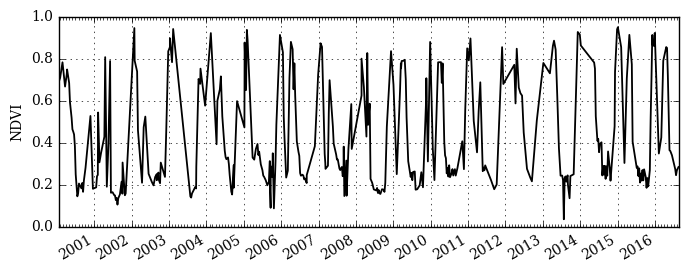

In [9]:
plot(ts['dates'], ts['ndvis'], 'NDVI')
#plot(ts['dates'], ts['evis'], 'EVI')

In [10]:
ts_2013 = ts.where((ts['dates'] >= numpy.datetime64('2012-09-01')) * (ts['dates'] < numpy.datetime64('2013-09-01')))

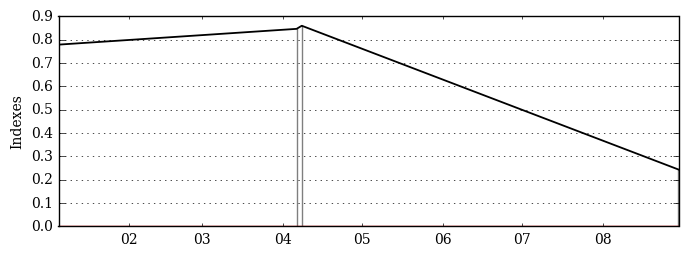

In [11]:
ts_2013_show = ts_2013.where(ts_2013['source']=='MOD')
stem(ts_2013_show['dates'], ts_2013_show['ndvis'], 'Indexes')

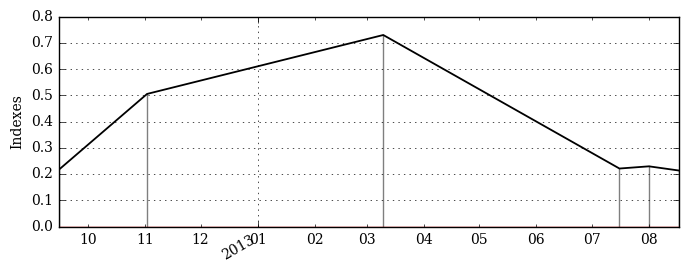

In [12]:
ts_2013_show = ts_2013.where(ts_2013['source']=='LE7')
stem(ts_2013_show['dates'], ts_2013_show['ndvis'], 'Indexes')

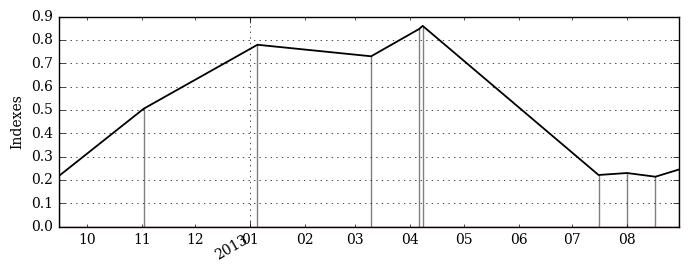

In [13]:
ts_2013_show = ts_2013.where((ts_2013['source']=='LE7') + (ts_2013['source']=='MOD'))
stem(ts_2013_show['dates'], ts_2013_show['ndvis'], 'Indexes')

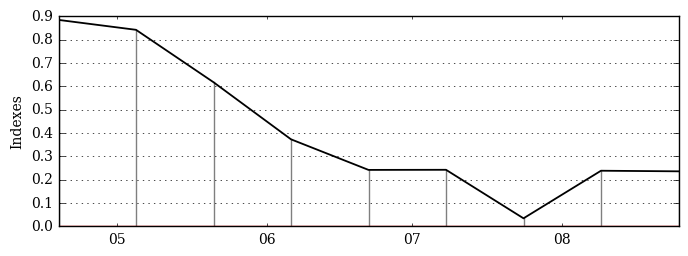

In [14]:
ts_2013_show = ts_2013.where(ts_2013['source']=='LC8')
stem(ts_2013_show['dates'], ts_2013_show['ndvis'], 'Indexes')

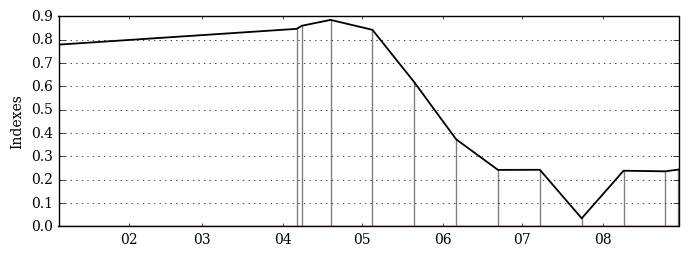

In [15]:
ts_2013_show = ts_2013.where((ts_2013['source']=='LC8') + (ts_2013['source']=='MOD'))
stem(ts_2013_show['dates'], ts_2013_show['ndvis'], 'Indexes')

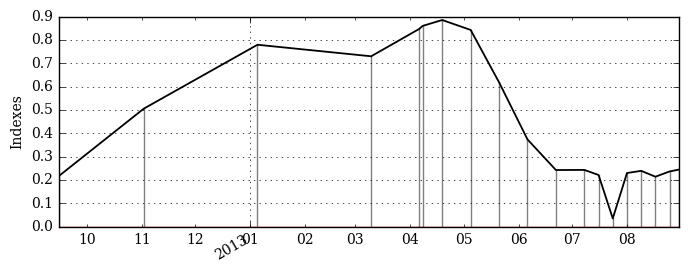

In [16]:
ts_2013_show = ts_2013
stem(ts_2013_show['dates'], ts_2013_show['ndvis'], 'Indexes')

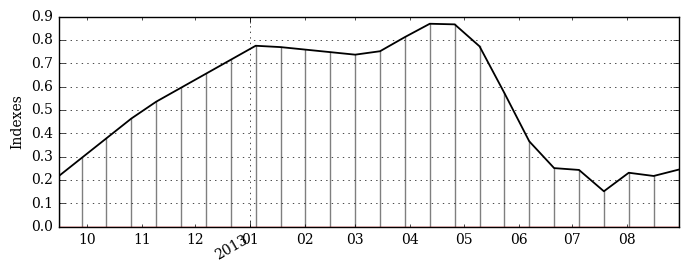

In [17]:
ts_2013_reg = ts_2013.regularize(reg_key='dates', slices=26, 
                                 interp_keys=['ndvis', 'evis'], method='linear')
stem(ts_2013_reg['dates'], (ts_2013_reg['ndvis']), 'Indexes')

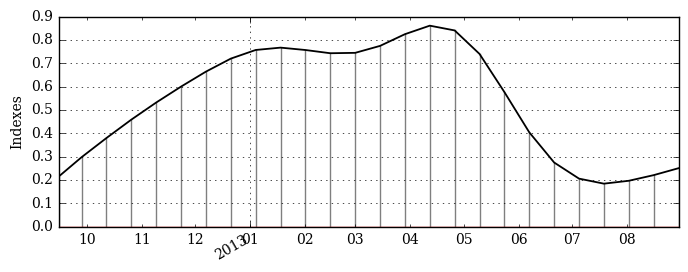

In [18]:
stem(ts_2013_reg['dates'], (whittaker_smooth(ts_2013_reg['ndvis'], 1.0)), 'Indexes')